In [1]:
import nltk

In [4]:
nltk.download_shell()   #downloading stopwords dataset

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


        Mahajan\AppData\Roaming\nltk_data...
      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [6]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [7]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

In [8]:
import pandas as pd

In [9]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Using these labeled ham and spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

# Exploratory Data Analysis

In [10]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [11]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [12]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


# Data Visualization

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

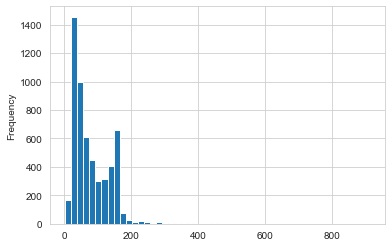

In [15]:
sns.set_style('whitegrid')
messages['length'].plot(bins=50, kind='hist') 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15640898>,
      dtype=object)

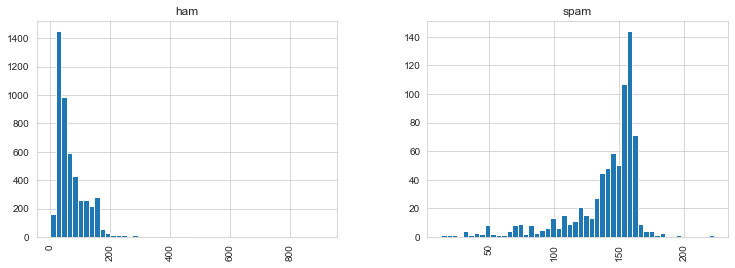

In [16]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters

# Text Pre-processing

Our main issue with our data is that it is all in text format (strings). We will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text.

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:

In [23]:
import string
from nltk.corpus import stopwords

In [24]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [26]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)


0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [27]:
# Show original dataframe
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

# Vectorization

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

Count how many times does a word occur in each message (Known as term frequency)

Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages.

In [30]:
messages_bow = bow_transformer.transform(messages['message'])

In [31]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [32]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [33]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


# Training a model

In [34]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

# Model Evaluation

In [35]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [36]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In the above "evaluation",we evaluated accuracy on the same data we used for training. You should never actually evaluate on the same dataset you train on!

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the training data during its model fitting and parameter tuning. The test data is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

# Train Test Split

In [50]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

#print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))
#The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572)


# Creating a Data Pipeline

In [40]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [41]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x157A0EC8>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [42]:
predictions = pipeline.predict(msg_test)

In [43]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1001
        spam       0.73      1.00      0.84       114

    accuracy                           0.96      1115
   macro avg       0.87      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115

